# This tutorial will demonstrate automatically and manual segmentation and downloading/uploading data with Neuroglancer

In [1]:
import brainlit
from brainlit.utils.ngl_pipeline import NeuroglancerSession
from brainlit.viz.swc import *
from brainlit.algorithms.generate_fragments import adaptive_thresh

## Find valid segments
In this cell, we set up a NeuroglancerSession object. Since segmentation ID numbers are not in order, we print out a list of valid IDs in some range `id_range`. Most segment IDs are in `range(300)`, additionally, segments `999` and `1000` are available.

In [2]:
# Optional: Print the IDs of segments in Neuroglancer
url = "s3://mouse-light-viz/precomputed_volumes/brain1"
ngl_skel = NeuroglancerSession(url+"_segments", mip=1)
working_ids = []
id_range = 12
for seg_id in range(id_range): 
    try:
        segment = ngl_skel.cv.skeleton.get(seg_id)
        working_ids.append(seg_id)
    except:
          pass
print(working_ids)

Downloading: 100%|██████████| 1/1 [00:00<00:00, 14.15it/s]

[2, 7, 11]


## Download SWC information
Download the information contained in a SWC file for labelled vertices of a given `seg_id` at a valid `mip` from AWS.

In [3]:
seg_id = 11
mip = 2
df = read_s3(url+"_segments", seg_id, mip)
#df.head()
df['sample'].size # the number of vertex IDs [1, 2, ..., df['sample'].size]

Downloading: 100%|██████████| 1/1 [00:00<00:00, 16.87it/s]
/Users/mattf/Applications/anaconda3/lib/python3.7/site-packages/brainlit/viz/swc.py:46: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  delim_whitespace=True,


2563

In [4]:
print(df)

      sample  structure       x       y       z    r  parent
0          1          0  1103.0  1721.0  1396.0  1.0      -1
1          2          0  1119.0  1705.0  1399.0  1.0       1
2          3          0  1133.0  1693.0  1401.0  1.0       2
3          4          0  1151.0  1678.0  1404.0  1.0       3
4         14          0  1171.0  1657.0  1408.0  1.0       4
5         29          0  1183.0  1644.0  1410.0  1.0      14
6         44          0  1192.0  1632.0  1413.0  1.0      29
7         57          0  1202.0  1618.0  1415.0  1.0      44
8         74          0  1212.0  1603.0  1416.0  1.0      57
9         87          0  1227.0  1583.0  1416.0  1.0      74
10        95          0  1237.0  1571.0  1416.0  1.0      87
11       113          0  1252.0  1558.0  1415.0  1.0      95
12       133          0  1261.0  1551.0  1414.0  1.0     113
13       165          0  1273.0  1539.0  1415.0  1.0     133
14       193          0  1282.0  1529.0  1415.0  1.0     165
15       214          0 

## Select vertices
Select a subset of the vertices in the downloaded SWC to view and segment.

In [5]:
subneuron_df = df[0:5] # choose vertices to use for the subneuron
vertex_list = subneuron_df['sample'].array 
print(vertex_list)

<PandasArray>
[1, 2, 3, 4, 14]
Length: 5, dtype: int64


## Download the Volume
Download the volume containing the specified vertices.

In [6]:
ngl = NeuroglancerSession(url, mip=mip)
buffer = [10, 10, 10]
img, bounds, vox_in_img_list = ngl.pull_vertex_list(seg_id, vertex_list, buffer = buffer, expand = True)

Downloading:   0%|          | 0/5 [00:00<?, ?it/s]









## Prepare plotting functions
We add some useful plotting functions to view the downloaded volume in matplotlib (2D) and Napari (3D).

In [7]:
# Reference: https://github.com/NeuroDataDesign/mouselit/blob/master/bijan/mouse_test/final%20notebook.ipynb

import matplotlib.pyplot as plt
import SimpleITK as sitk
import numpy as np
import napari


def plot_2d(img, title=None, margin=0.05, dpi=80):
    nda = sitk.GetArrayFromImage(img)
    spacing = img.GetSpacing()

    if nda.ndim == 3:
        c = nda.shape[-1]

        if c not in (3, 4):
            nda = nda[nda.shape[0] // 2, :, :]

    elif nda.ndim == 4:
        c = nda.shape[-1]

        if c not in (3, 4):
            raise RuntimeError("Unable to show 3D-vector Image")

        nda = nda[nda.shape[0] // 2, :, :, :]

    xsize = nda.shape[1] * 2
    ysize = nda.shape[0] * 2

    figsize = (1 + margin) * xsize / dpi, (1 + margin) * ysize / dpi

    plt.figure(figsize=figsize, dpi=dpi, tight_layout=True)
    ax = plt.gca()

    extent = (0, xsize * spacing[0], ysize * spacing[1], 0)

    t = ax.imshow(nda, extent=extent, interpolation=None)

    if nda.ndim == 2:
        t.set_cmap("gray")

    if title:
        plt.title(title)

    plt.show()


def plot_3d(img, xslices=[], yslices=[], zslices=[], title=None, margin=0.05, dpi=80):
    img_xslices = [img[s, :, :] for s in xslices]
    img_yslices = [img[:, s, :] for s in yslices]
    img_zslices = [img[:, :, s] for s in zslices]

    maxlen = max(len(img_xslices), len(img_yslices), len(img_zslices))

    img_null = sitk.Image([0, 0], img.GetPixelID(), img.GetNumberOfComponentsPerPixel())

    img_slices = []
    d = 0

    if len(img_xslices):
        img_slices += img_xslices + [img_null] * (maxlen - len(img_xslices))
        d += 1

    if len(img_yslices):
        img_slices += img_yslices + [img_null] * (maxlen - len(img_yslices))
        d += 1

    if len(img_zslices):
        img_slices += img_zslices + [img_null] * (maxlen - len(img_zslices))
        d += 1

    if maxlen != 0:
        if img.GetNumberOfComponentsPerPixel() == 1:
            img = sitk.Tile(img_slices, [maxlen, d])
        else:
            img_comps = []
            for i in range(0, img.GetNumberOfComponentsPerPixel()):
                img_slices_c = [sitk.VectorIndexSelectionCast(s, i) for s in img_slices]
                img_comps.append(sitk.Tile(img_slices_c, [maxlen, d]))
            img = sitk.Compose(img_comps)

    plot_2d(img, title, margin, dpi)


def napari_viewer(img, labels=None, shapes=None, label_name="Segmentation"):
    viewer = napari.view_image(np.squeeze(np.array(img)))
    if labels is not None:
        viewer.add_labels(labels, name=label_name)
    if shapes is not None:
        viewer.add_shapes(data=shapes, shape_type='path', edge_color='blue', name='Skeleton')
    return viewer

Let's take a look at the downloaded volume. Napari will open in a new window.

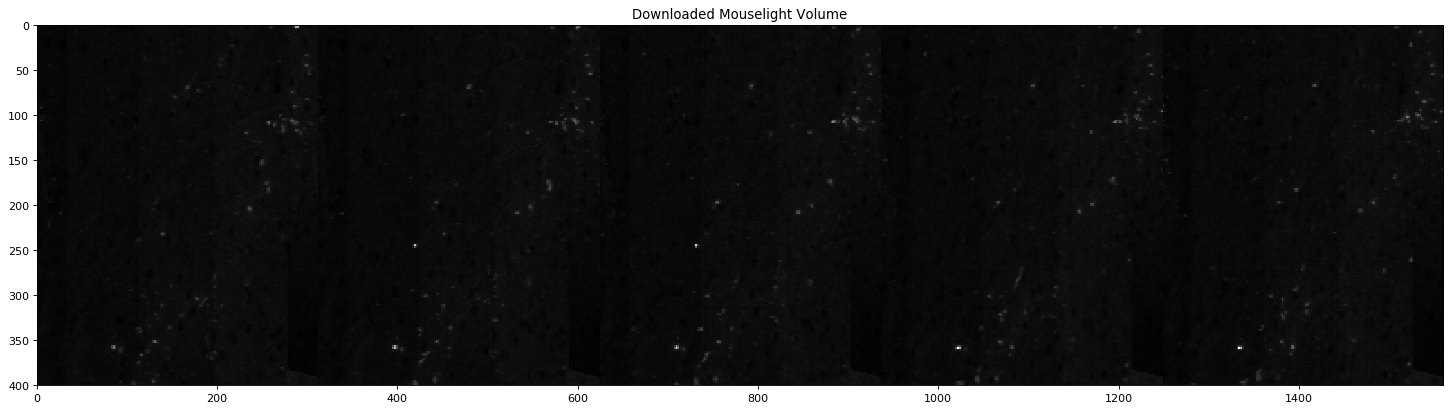

In [9]:
%gui qt
plot_3d(sitk.GetImageFromArray(np.squeeze(img), isVector=False), zslices=range(48,53), title = "Downloaded Mouselight Volume")
napari_viewer(img)

We get a `corrected_subneuron_df` that contains `(x,y,z)` coordinates within the downloaded volume for the vertices in the SWC.

In [10]:
corrected_subneuron_df = generate_df_subset(subneuron_df, vox_in_img_list)
print(corrected_subneuron_df)

   sample  structure    x    y    z    r  parent
0       1          0   72   53  128  1.0      -1
1       2          0   69   60  122  1.0       1
2       3          0   69   63  115  1.0       2
3       4          0   74   63  108  1.0       3
4      14          0  155  162   57  1.0       4


Convert the SWC to a graph and print some information about the graph.

In [11]:
G = df_to_graph(corrected_subneuron_df)
print('Number of nodes:', len(G.nodes))
print('Number of edges:', len(G.edges))
print('Sample 1 coordinates (x,y,z):', G.nodes[1])
paths = graph_to_paths(G)
print('Number of paths:', len(paths))

Number of nodes: 5
Number of edges: 4
Sample 1 coordinates (x,y,z): {'x': 72, 'y': 53, 'z': 128}
Number of paths: 1


We can display the SWC on the Volume

In [12]:
%gui qt
napari_viewer(img, shapes=paths)

## Automatically segment the neuron
We start by converting the seed points to a format used by the thresholding.

In [13]:
seed = [adaptive_thresh.get_seed(sample)[1] for sample in vox_in_img_list]
print(seed)

[(128, 53, 72), (122, 60, 69), (115, 63, 69), (108, 63, 74), (57, 162, 155)]


Next, we compute a confidence-connected threshold segmentation.

In [20]:
labels = adaptive_thresh.confidence_connected_threshold(img, seed, num_iter=1, multiplier=0.7)

We can display the volume, SWC, and segmentation in Napari.

In [21]:
%gui qt
napari_viewer(img, labels=labels, shapes=paths, label_name="Confidence-Connected Threshold")

## Steps to Manually Edit Labels
Labels can be manually edited following these steps:

1. Ensure Napari is in 2D-slice viewing, not 3D view. (The second button from the bottom left)
2. Click the image layer and adjust the contrast limits as desired.
3. Click the "Confidence-Connected Threshold Layer"
4. Click the paintbrush tool and adjust the brush size. Ensure that "label" is set to 1 to paint and 0 to erase.
5. Click and drag on the image to adjust labels. Changes are saved automatically, and CMD-Z to undo is supported.

Extract the manual labels for uploading.

In [22]:
manual_labels = viewer.layers['Confidence-Connected Threshold'].data

Upload the segmentation to AWS.

In [23]:
%%capture
ngl_upload = NeuroglancerSession(url+"_seg", mip=mip)
ngl_upload.push(manual_labels, bounds);

Confirm that the upload was successful. It was!

In [24]:
downloaded_labels = ngl_upload.pull_bounds_seg(bounds)

Downloading:   0%|          | 0/5 [00:00<?, ?it/s]









In [25]:
print(np.all(manual_labels == downloaded_labels))

True
